<div align='center'><font size="5" color='#353B47'>Image Segmentation</font></div>
<div align='center'><font size="4" color="#353B47">Using U-Net with Keras</font></div>
<br>
<hr>

## <div id="summary">Table of contents</div>

**<font size="2"><a href="#chap1">1. Introduction</a></font>**
**<br><font size="2"><a href="#chap2">2. Load Data</a></font>**
**<br><font size="2"><a href="#chap3">3. Get Masks</a></font>**
**<br><font size="2"><a href="#chap4">4. Training Model</a></font>**
**<br><font size="2"><a href="#chap5">5. Predict and Visualize</a></font>**

# <div id="chap1">1. Introduction</div>

<hr>

# <div id="chap2">Load Data</div>

Libraries

In [1]:
import tensorflow as tf
import zipfile
import numpy as np
import random
import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# # Load the extension and start TensorBoard

# %load_ext tensorboard
# %tensorboard --logdir logs

Constants

In [57]:
SEED = 42
np.random.seed = SEED

#UNZIP_PATH = '../input/data-science-bowl-2018/'
#C:\Users\Kasia\Documents\GitHub\CameraXinJava2\app\src\main\assets\processed
TRAIN_PATH = r'C:\Users\Kasia\Documents\GitHub\CameraXinJava2\app\src\main\assets\processed\train'
TEST_PATH = r'C:\Users\Kasia\Documents\GitHub\CameraXinJava2\app\src\main\assets\processed\test'
VAL_PATH = r'C:\Users\Kasia\Documents\GitHub\CameraXinJava2\app\src\main\assets\processed\val'

TRAIN_Y_PATH =r'C:\Users\Kasia\Documents\GitHub\CameraXinJava2\app\src\main\assets\processed\train_labels'
TEST_Y_PATH= r'C:\Users\Kasia\Documents\GitHub\CameraXinJava2\app\src\main\assets\processed\test_labels'
VAL_Y_PATH =r'C:\Users\Kasia\Documents\GitHub\CameraXinJava2\app\src\main\assets\processed\val_labels'


IMG_WIDTH_TEST = 800 #512
IMG_HEIGHT_TEST = 800 #384
IMG_CHANNELS_TEST = 3

IMG_WIDTH_TRAIN = 800 #512
IMG_HEIGHT_TRAIN = 800 #384
IMG_CHANNELS_TRAIN = 3

In [12]:
from PIL import Image

In [39]:
for element in os.listdir(TEST_Y_PATH):
    print(element)
    image = plt.imread(os.path.join(TEST_Y_PATH, element))
    print(image.shape)

4c46b91a-e402-11e8-97db-0242ac1c0002.jpg
(800, 800, 3)
4c4a6402-e402-11e8-97db-0242ac1c0002.jpg
(800, 800, 3)


(800, 800, 3)


In [58]:
# get list of all subfolders
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
val_ids = next(os.walk(VAL_PATH))[1]

# <div id="chap3">Get Masks</div>

In [ ]:
#path

2it [00:00,  6.53it/s]
4it [00:00, 56.64it/s]
46it [00:00, 61.20it/s]


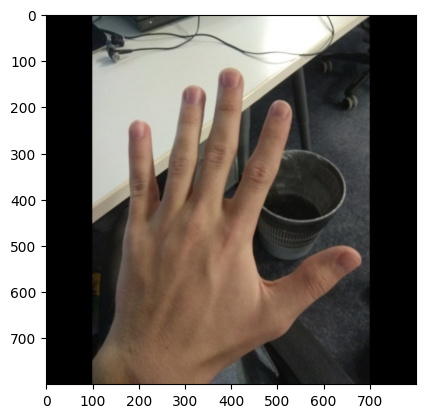

In [75]:
X_test = np.zeros((len(os.listdir(TEST_PATH)), IMG_WIDTH_TEST, IMG_HEIGHT_TEST, IMG_CHANNELS_TEST))

for i, element in tqdm(enumerate(os.listdir(TEST_PATH))):
    image = plt.imread(os.path.join(TEST_PATH, element))
    X_test[i] = image
    plt.imshow(image)



Val_train = np.zeros((len(os.listdir(VAL_PATH)), IMG_WIDTH_TRAIN, IMG_HEIGHT_TRAIN, IMG_CHANNELS_TRAIN))

for i, element in tqdm(enumerate(os.listdir(VAL_PATH))):
    image = plt.imread(os.path.join(VAL_PATH, element))
    Val_train[i] = image

    
X_train = np.zeros((len(os.listdir(TRAIN_PATH)), IMG_WIDTH_TRAIN, IMG_HEIGHT_TRAIN, IMG_CHANNELS_TRAIN))

for i, element in tqdm(enumerate(os.listdir(TRAIN_PATH))):
    image = plt.imread(os.path.join(TRAIN_PATH, element))
    X_train[i] = image

In [37]:
X_test.shape

(2, 800, 800, 3)

For maska

In [98]:
Y_train = np.zeros((len(os.listdir(TRAIN_Y_PATH)), IMG_WIDTH_TEST, IMG_HEIGHT_TEST))

for i, element in tqdm(enumerate(os.listdir(TRAIN_Y_PATH))):
    image = plt.imread(os.path.join(TRAIN_Y_PATH, element))
    Y_train[i] = np.where(np.mean(image, axis=2) > 254, 1, 0)


Y_valid = np.zeros((len(os.listdir(VAL_Y_PATH)), IMG_WIDTH_TEST, IMG_HEIGHT_TEST))

for i, element in tqdm(enumerate(os.listdir(VAL_Y_PATH))):
    image = plt.imread(os.path.join(VAL_Y_PATH, element))
    Y_valid[i] = np.where(np.mean(image, axis=2) > 254, 1, 0)

Y_test = np.zeros((len(os.listdir(TEST_Y_PATH)), IMG_WIDTH_TRAIN, IMG_HEIGHT_TRAIN))

for i, element in tqdm(enumerate(os.listdir(TEST_Y_PATH))):
    image = plt.imread(os.path.join(TEST_Y_PATH, element))
    Y_test[i] = np.where(np.mean(image, axis=2) > 254, 1, 0)
    # print(Y_test[i].shape, np.mean(Y_test[i], axis=2).shape, np.unique(np.where(np.mean(Y_test[i], axis=2) > 250, 1, 0)))
    # plt.figure()
    # plt.imshow(image)
    # plt.show()

    # plt.figure()
    # plt.imshow(Y_test[i], cmap='binary_r')
    # plt.show()

46it [00:00, 51.80it/s]
4it [00:00, 51.23it/s]
2it [00:00, 51.18it/s]


# <div id="chap4">4. Training Model</div>

In [61]:
IMAGE_WIDTH = IMG_WIDTH_TRAIN 
IMAGE_HEIGHT = IMG_HEIGHT_TRAIN
IMG_CHANNELS = IMG_CHANNELS_TRAIN


In [99]:
inputs = tf.keras.layers.Input((IMG_WIDTH_TRAIN, IMG_HEIGHT_TRAIN, IMG_CHANNELS_TRAIN))
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) # normalization

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(s) # start with normal distributed weights
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = "same")(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = "same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = "same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = "same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)



In [100]:
# Dice similarity function
import keras.backend as K

def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 800, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_4 (Lambda)              (None, 800, 800, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 800, 800, 16  448         ['lambda_4[0][0]']               
                                )                                                                 
                                                                                            

In [101]:
# Callbacks
# checkpoiter = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs')
            ]

In [102]:
results = model.fit(
    X_train, 
    Y_train, 
    #validation_split = 0.1, 
    validation_data=(Val_train, Y_valid),
    batch_size = 16, 
    epochs = 20, 
    callbacks = callbacks)

Epoch 1/5
3/3 [==============================] - 108s 33s/step - loss: 0.4785 - dice_coef: 0.0173 - val_loss: 0.3550 - val_dice_coef: 0.0103
Epoch 2/5
3/3 [==============================] - 96s 32s/step - loss: 0.3741 - dice_coef: 0.0079 - val_loss: 0.2655 - val_dice_coef: 0.0052
Epoch 3/5
3/3 [==============================] - 93s 30s/step - loss: 0.4324 - dice_coef: 0.0096 - val_loss: 0.3622 - val_dice_coef: 0.0220
Epoch 4/5
3/3 [==============================] - 93s 30s/step - loss: 0.3101 - dice_coef: 0.0150 - val_loss: 0.2595 - val_dice_coef: 0.0262
Epoch 5/5
3/3 [==============================] - 96s 31s/step - loss: 0.1692 - dice_coef: 0.0395 - val_loss: 0.1856 - val_dice_coef: 0.0418


In [103]:
#results = model.fit(    X_train,     Y_train,     validation_split = 0.1,     batch_size = 16,     epochs = 5,     callbacks = callbacks)

In [132]:
model.save('shitty_model.h5')

dependencies = {'dice_coef': dice_coef}

modell = tf.keras.models.load_model('shitty_model.h5', custom_objects=dependencies)

In [133]:
modell.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 800, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_4 (Lambda)              (None, 800, 800, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 800, 800, 16  448         ['lambda_4[0][0]']               
                                )                                                                 
                                                                                            

In [151]:
image = plt.imread(r"C:\Users\Kasia\Documents\GitHub\nails_segmentation\zdjecie_do_sklasyfikowania.jpg")
print(image.shape)

(800, 800, 3)


In [153]:
#print(image_wanted.shape)
#modell.predict(image_wanted.reshape((800, 800, 3)))
image_wanted = plt.imread(r"C:\Users\Kasia\Documents\GitHub\nails_segmentation\zdjecie_do_sklasyfikowania.jpg")
modell.predict(image_wanted)

ValueError: in user code:

    File "c:\Users\Kasia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Kasia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Kasia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Kasia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\Kasia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Kasia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_8" is incompatible with the layer: expected shape=(None, 800, 800, 3), found shape=(32, 800, 3)


# <div id="chap5">5. Predict and Visualize</div>

In [104]:
# Predictions
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose = 1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 1s 708ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


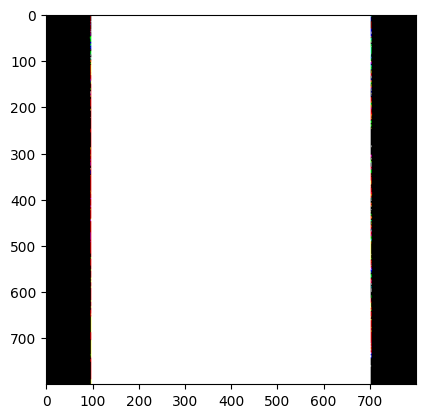

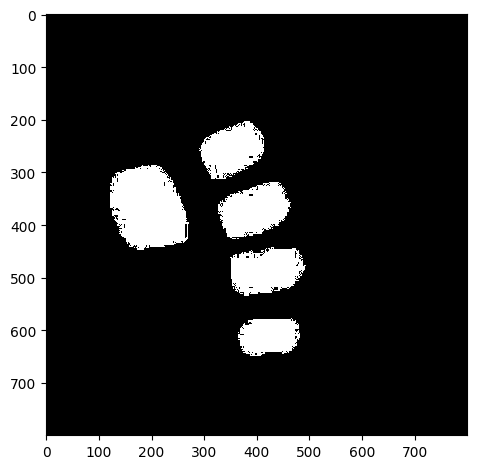

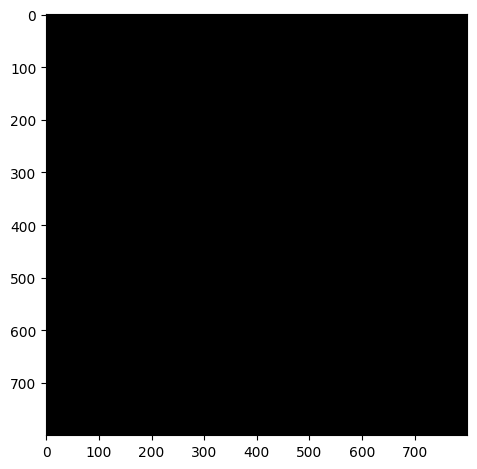

In [119]:
# Sanity check on random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.squeeze(X_train[ix]))
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


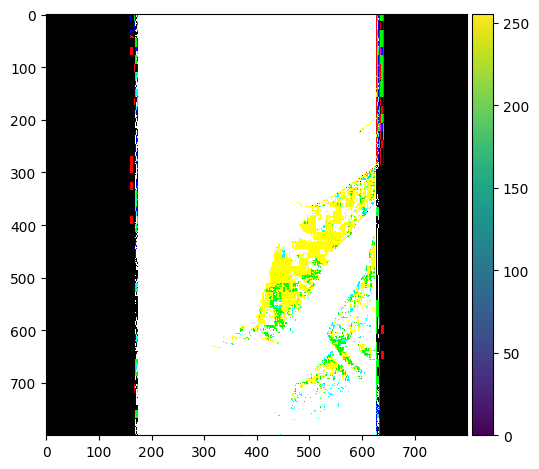

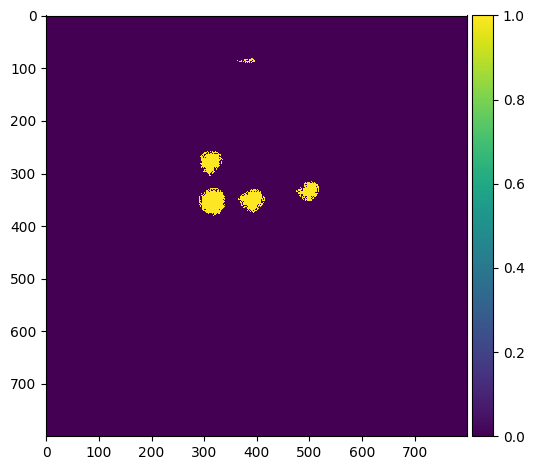

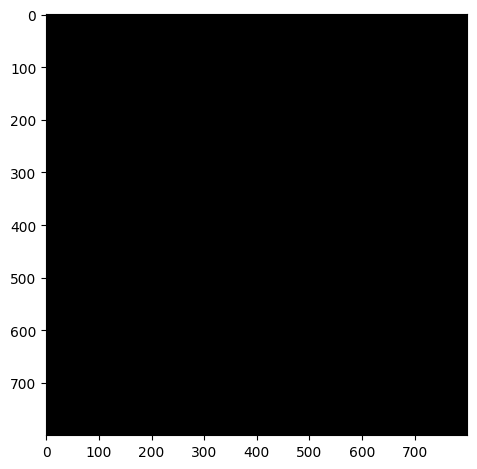

In [120]:
# Sanity check on random val samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(X_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

<hr>
<br>
<div align='justify'><font color="#353B47" size="4">Thank you for taking the time to read this notebook. I hope that I was able to answer your questions or your curiosity and that it was quite understandable. <u>any constructive comments are welcome</u>. They help me to progress and motivate me to share better quality content. I am above all a passionate person who tries to advance my knowledge but also that of others. If you liked it, just let me know <u>i'd appreciate.</u> </font></div>
<br>
<div align='center'><font color="#353B47" size="3">Thank you and may passion guide you.</font></div>